In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json

# Task 1: Load and examine the data

In [2]:
raw_data = np.load('plantdata.npy', allow_pickle=True)

In [3]:
print(f"Data shape: {raw_data.shape}")
print(f"Data type: {type(raw_data)}")

Data shape: (15434, 12)
Data type: <class 'numpy.ndarray'>


In [4]:
n_missing = np.isnan(raw_data).sum()
total_values = raw_data.size
missing_ratio = n_missing / total_values

print(f"\nTotal missing values: {n_missing}")
print(f"\nMissing values ratio: {missing_ratio:.4f} ({missing_ratio*100:.2f}%)")


Total missing values: 20873

Missing values ratio: 0.1127 (11.27%)


In [5]:
for col_idx in range(raw_data.shape[1]):
    col_data = raw_data[:, col_idx]
    col_data_clean = col_data[~np.isnan(col_data)]
    
    print(f"Column {col_idx}:")
    print(f"  Min: {np.min(col_data_clean):.2f}")
    print(f"  Vidurkis: {np.mean(col_data_clean):.2f}")
    print(f"  Mediana: {np.median(col_data_clean):.2f}")
    print(f"  Max: {np.max(col_data_clean):.2f}")

Column 0:
  Min: 0.80
  Vidurkis: 97.52
  Mediana: 98.10
  Max: 144.00
Column 1:
  Min: 0.00
  Vidurkis: 0.30
  Mediana: 0.30
  Max: 1.00
Column 2:
  Min: 4.00
  Vidurkis: 127.41
  Mediana: 128.00
  Max: 228.00
Column 3:
  Min: 0.00
  Vidurkis: 1.59
  Mediana: 2.00
  Max: 4.00
Column 4:
  Min: 0.00
  Vidurkis: 0.50
  Mediana: 0.00
  Max: 2.00
Column 5:
  Min: 1.70
  Vidurkis: 42.21
  Mediana: 42.60
  Max: 78.20
Column 6:
  Min: 0.00
  Vidurkis: 3.66
  Mediana: 5.00
  Max: 12.00
Column 7:
  Min: 2.00
  Vidurkis: 38.37
  Mediana: 39.00
  Max: 71.00
Column 8:
  Min: 0.00
  Vidurkis: 1.51
  Mediana: 2.00
  Max: 4.00
Column 9:
  Min: 0.10
  Vidurkis: 84.14
  Mediana: 1.50
  Max: 3322.00
Column 10:
  Min: 0.28
  Vidurkis: 15.29
  Mediana: 12.27
  Max: 92.88
Column 11:
  Min: 0.00
  Vidurkis: 4.58
  Mediana: 3.68
  Max: 28.12


In [6]:
assert type(raw_data) == np.ndarray
assert n_missing == 20873

# Task 2: Make data more convenient to work with


In [7]:
raw_df = pd.DataFrame(raw_data)
print(f"\nCreated DataFrame with shape: {raw_df.shape}")


Created DataFrame with shape: (15434, 12)


In [8]:
url = 'https://raw.githubusercontent.com/Tallivm/vu-python/refs/heads/main/plant_datasheet.json'
with urllib.request.urlopen(url) as response:
    datasheet = json.loads(response.read().decode())

datasheet["column_names"] = datasheet.pop("column names")

print(f"Loaded datasheet with keys: {list(datasheet.keys())}")

Loaded datasheet with keys: ['mapping', 'column_names']


In [9]:
named_df = raw_df.copy()
named_df.columns = datasheet['column_names']

print(f"\nRenamed columns: {list(named_df.columns)}")


Renamed columns: ['plant_height', 'stem_bending', 'leaf_size', 'leaf_shape_type', 'leaf_surface_type', 'flower_radius', 'n_petals', 'petal_size', 'petal_color', 'snail_age', 'snail_body_length', 'snail_eye_length']


In [10]:
for column_name, mapping_dict in datasheet['mapping'].items():
    if column_name in named_df.columns:
        reverse_dict = {v: k for k, v in mapping_dict.items()}
        named_df[column_name] = named_df[column_name].apply(lambda x: reverse_dict.get(int(x)) if pd.notna(x) else x)

In [11]:
assert type(raw_df) == pd.DataFrame
assert type(named_df) == pd.DataFrame
assert type(datasheet) == dict
assert raw_df.columns[0] == 0
assert named_df.columns[0] == 'plant_height'
assert named_df.loc[1, 'petal_color'] == 'red'

# Task 3: Detect problematic values

In [12]:
def print_missing_values_per_column():
    print(named_df.isna().sum())

print("\nMissing values per column:")
print_missing_values_per_column()


Missing values per column:
plant_height            0
stem_bending            7
leaf_size               4
leaf_shape_type         0
leaf_surface_type       0
flower_radius        6945
n_petals                0
petal_size           6945
petal_color          6945
snail_age               8
snail_body_length       8
snail_eye_length       11
dtype: int64


In [13]:
print("\nUnique values in categorical columns:")
categorical_cols = named_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {named_df[col].unique()}")


Unique values in categorical columns:
leaf_shape_type: ['lanceolate' 'elliptical' 'cordate' 'ovate' 'reniform']
leaf_surface_type: ['waxy' 'hairy' 'smooth']
petal_color: [nan 'red' 'purple' 'white' 'yellow' 'blue']


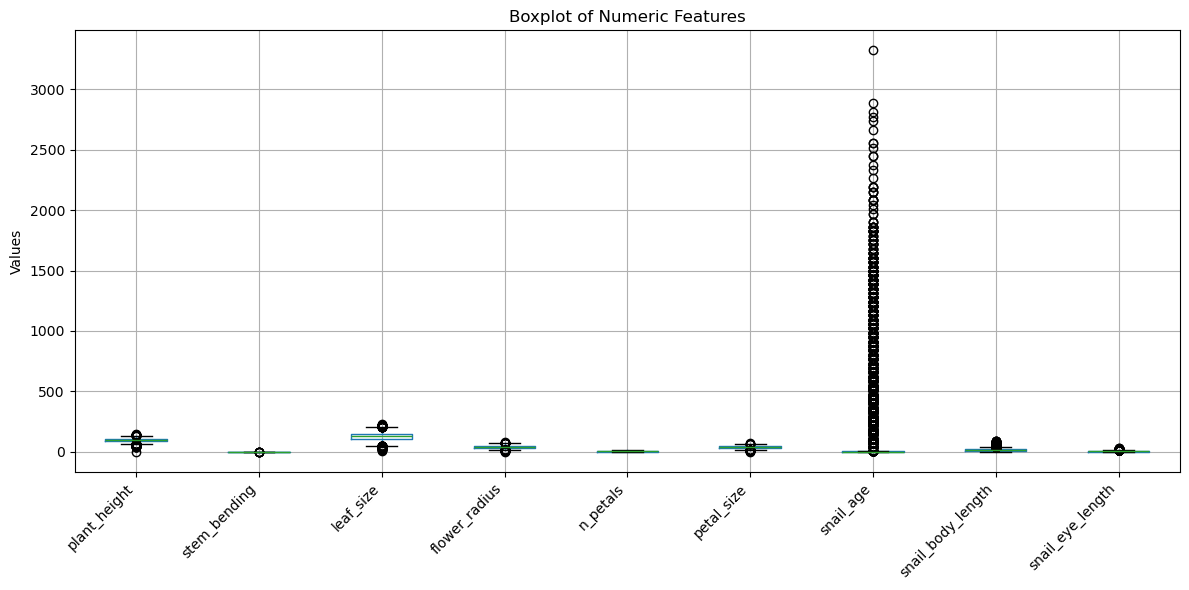

In [14]:
numeric_cols = named_df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12, 6))
named_df[numeric_cols].boxplot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Values')
plt.title('Boxplot of Numeric Features')
plt.tight_layout()
plt.savefig('task3_boxplot.pdf')
plt.show()

In [15]:
def count_outliers_iqr(series):
    """Counts outliers using the IQR method"""
    clean_series = series.dropna()
    Q1 = clean_series.quantile(0.25)
    Q3 = clean_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (clean_series < lower_bound) | (clean_series > upper_bound)
    return outliers.sum()


print("\nOutliers per numeric column (IQR method):")
n_outliers_total = 0
for col in numeric_cols:
    n_outliers = count_outliers_iqr(named_df[col])
    n_outliers_total += n_outliers
    print(f"{col}: {n_outliers}")

print(f"\nTotal outliers: {n_outliers_total}")


Outliers per numeric column (IQR method):
plant_height: 148
stem_bending: 6
leaf_size: 130
flower_radius: 65
n_petals: 0
petal_size: 36
snail_age: 2386
snail_body_length: 577
snail_eye_length: 569

Total outliers: 3917


In [16]:
assert n_outliers_total == 3917

# Task 4: Clean the data

In [17]:
clean_df = named_df.copy()

print("\nSnail age statistics before cleaning:")
print(clean_df['snail_age'].describe())

clean_df['snail_age'] = clean_df['snail_age'].apply(
    lambda x: x / 365.25 if pd.notna(x) and x > 15 else x
)

print("\nSnail age statistics after cleaning:")
print(clean_df['snail_age'].describe())


Snail age statistics before cleaning:
count    15426.000000
mean        84.137917
std        259.606693
min          0.100000
25%          0.800000
50%          1.500000
75%          2.900000
max       3322.000000
Name: snail_age, dtype: float64

Snail age statistics after cleaning:
count    15426.000000
mean         1.529106
std          1.161328
min          0.098563
25%          0.700000
50%          1.200000
75%          2.097194
max          9.300000
Name: snail_age, dtype: float64


In [18]:
mask = clean_df['snail_eye_length'] > 0.4 * clean_df['snail_body_length']
clean_df.loc[mask, 'snail_eye_length'] = 0.2 * clean_df['snail_body_length'][mask]

In [19]:
print(f"\nFixed {mask.sum()} incorrect snail_eye_length values")


Fixed 288 incorrect snail_eye_length values


In [20]:
clean_df = clean_df.dropna(subset=['plant_height', 'snail_age', 'snail_body_length'])

clean_df['petal_color'] = clean_df['petal_color'].fillna('N/A')

clean_df['n_petals'] = clean_df['n_petals'].fillna(0)

clean_df['leaf_surface_type'] = clean_df['leaf_surface_type'].fillna(0)

clean_df['snail_eye_length'] = clean_df['snail_eye_length'].fillna(
    0.2 * clean_df['snail_body_length']
)

print(f"\nDataFrame shape after cleaning: {clean_df.shape}")
print(f"Remaining missing values: {clean_df.isna().sum().sum()}")


DataFrame shape after cleaning: (15418, 12)
Remaining missing values: 13885


In [21]:
print("Visi stulpeliai po pervardinimo:")
print(list(named_df.columns))

Visi stulpeliai po pervardinimo:
['plant_height', 'stem_bending', 'leaf_size', 'leaf_shape_type', 'leaf_surface_type', 'flower_radius', 'n_petals', 'petal_size', 'petal_color', 'snail_age', 'snail_body_length', 'snail_eye_length']


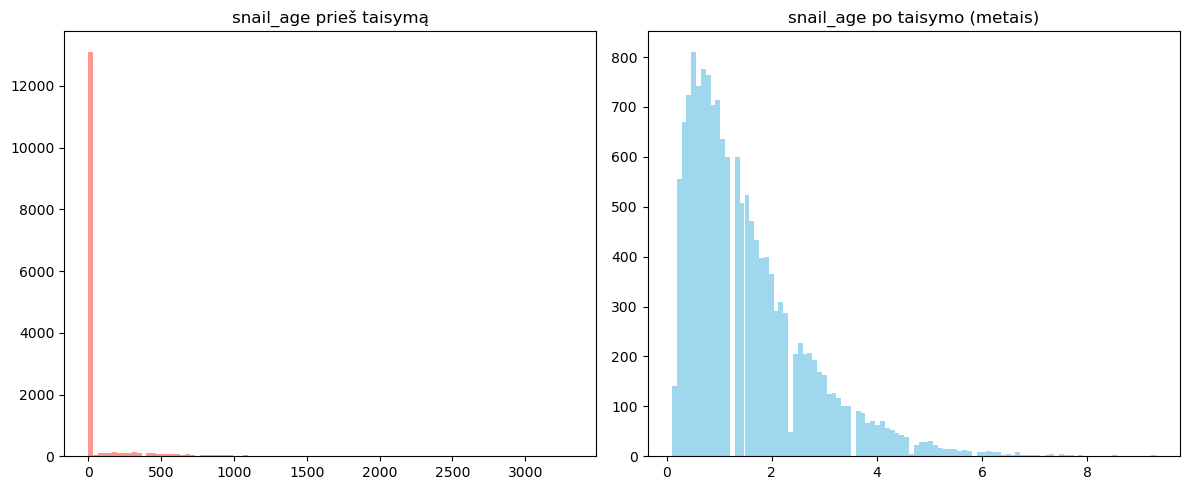

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(named_df['snail_age'].dropna(), bins=100, color='salmon', alpha=0.8)
axes[0].set_title('snail_age prieš taisymą')
axes[1].hist(clean_df['snail_age'], bins=100, color='skyblue', alpha=0.8)
axes[1].set_title('snail_age po taisymo (metais)')
plt.tight_layout()
plt.show()

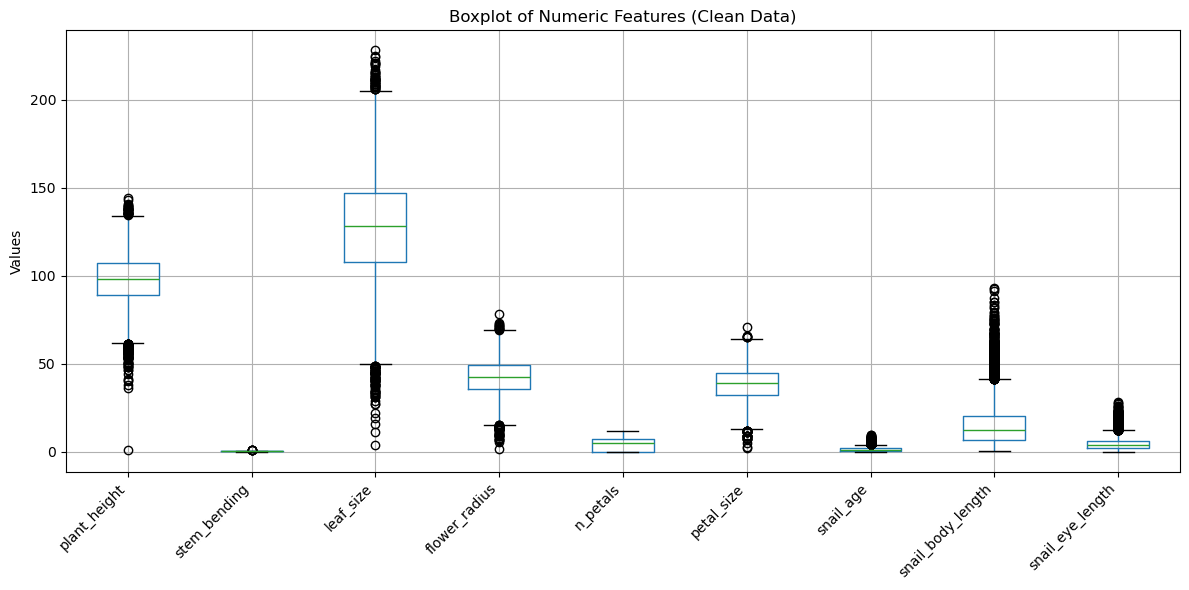

In [23]:
plt.figure(figsize=(12, 6))
clean_df[numeric_cols].boxplot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Values')
plt.title('Boxplot of Numeric Features (Clean Data)')
plt.tight_layout()
plt.savefig('task4_boxplot_clean.pdf')
plt.show()

In [24]:
assert list(named_df.columns) == list(clean_df.columns)
assert len(named_df) > len(clean_df)

# Task 5: Visualize the data

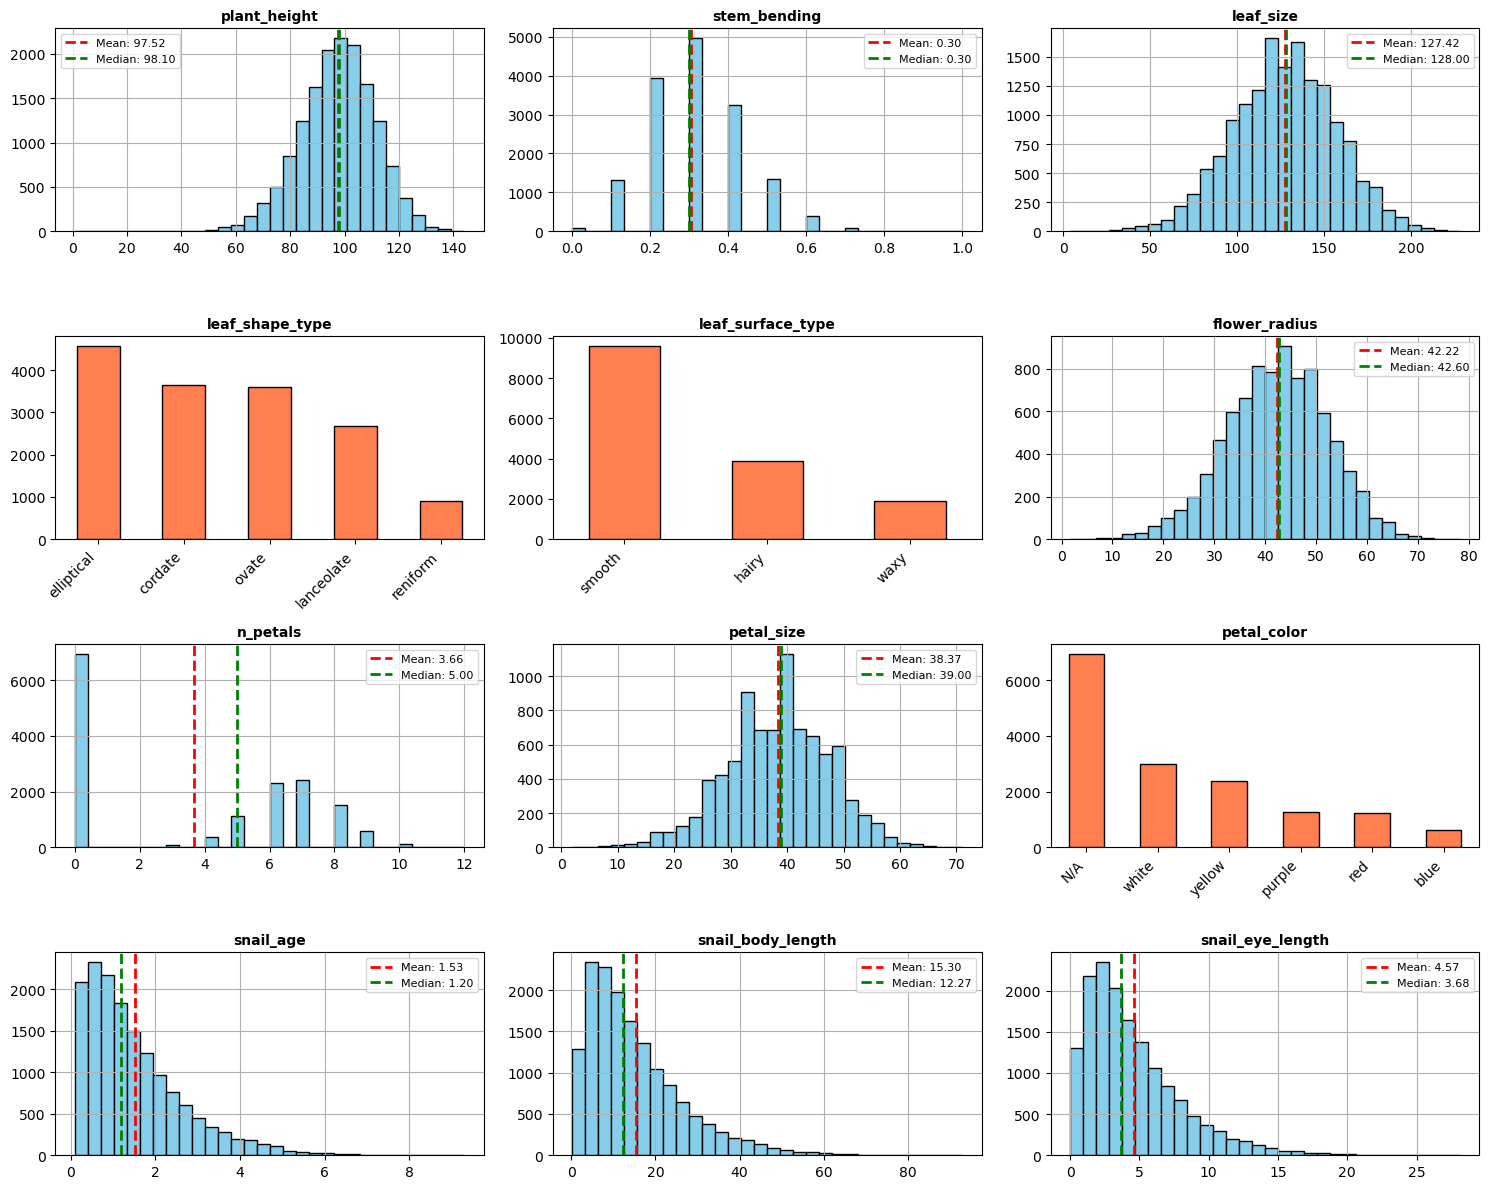

Saved: data_features.pdf


In [25]:
n_features = len(clean_df.columns)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(clean_df.columns):
    ax = axes[idx]
    
    if clean_df[col].dtype in [np.number, 'int64', 'float64']:
        clean_df[col].hist(bins=30, ax=ax, color='skyblue', edgecolor='black')
        
        mean_val = clean_df[col].mean()
        median_val = clean_df[col].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        ax.legend(fontsize=8)
    else:
        value_counts = clean_df[col].value_counts()
        value_counts.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.set_xlabel('')

for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('data_features.pdf')
plt.show()

print("Saved: data_features.pdf")

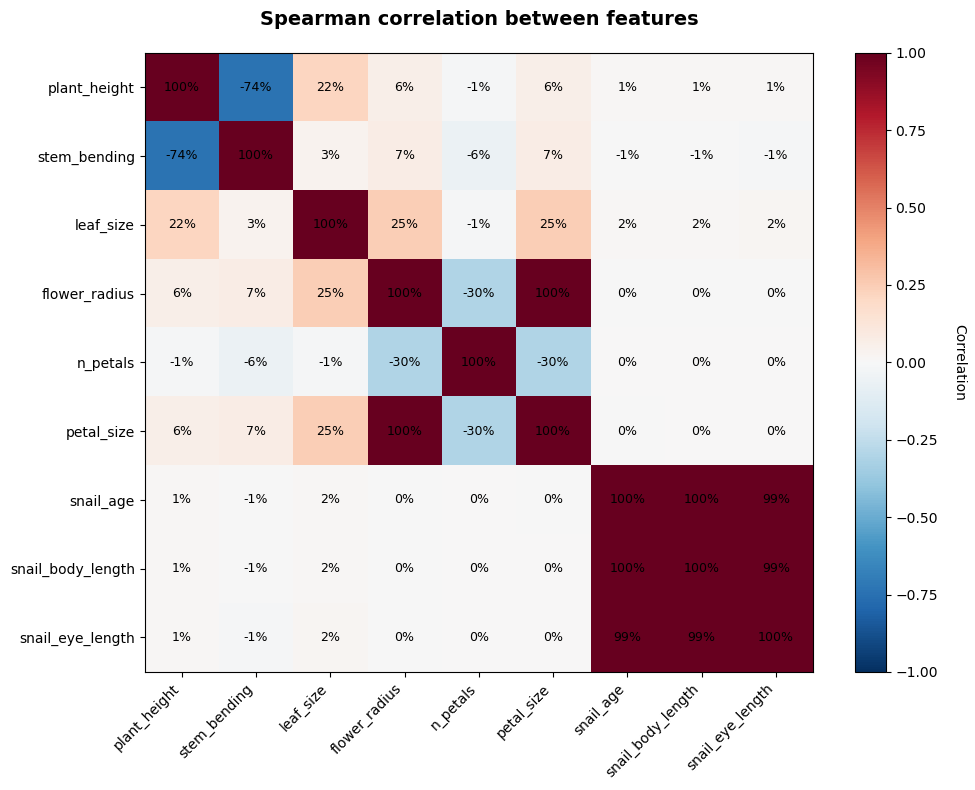

Saved: data_correlation.pdf


In [26]:
numeric_data = clean_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr(method='spearman')

correlation_percent = (correlation_matrix * 100).round(0).astype(int)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20)

ax.set_xticks(np.arange(len(numeric_data.columns)))
ax.set_yticks(np.arange(len(numeric_data.columns)))
ax.set_xticklabels(numeric_data.columns, rotation=45, ha='right')
ax.set_yticklabels(numeric_data.columns)

for i in range(len(numeric_data.columns)):
    for j in range(len(numeric_data.columns)):
        text = ax.text(j, i, f"{correlation_percent.iloc[i, j]}%",
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Spearman correlation between features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('data_correlation.pdf')
plt.show()

print("Saved: data_correlation.pdf")


Least correlated: n_petals vs snail_body_length (r=0.000)
Most correlated: snail_age vs snail_body_length (r=0.999)


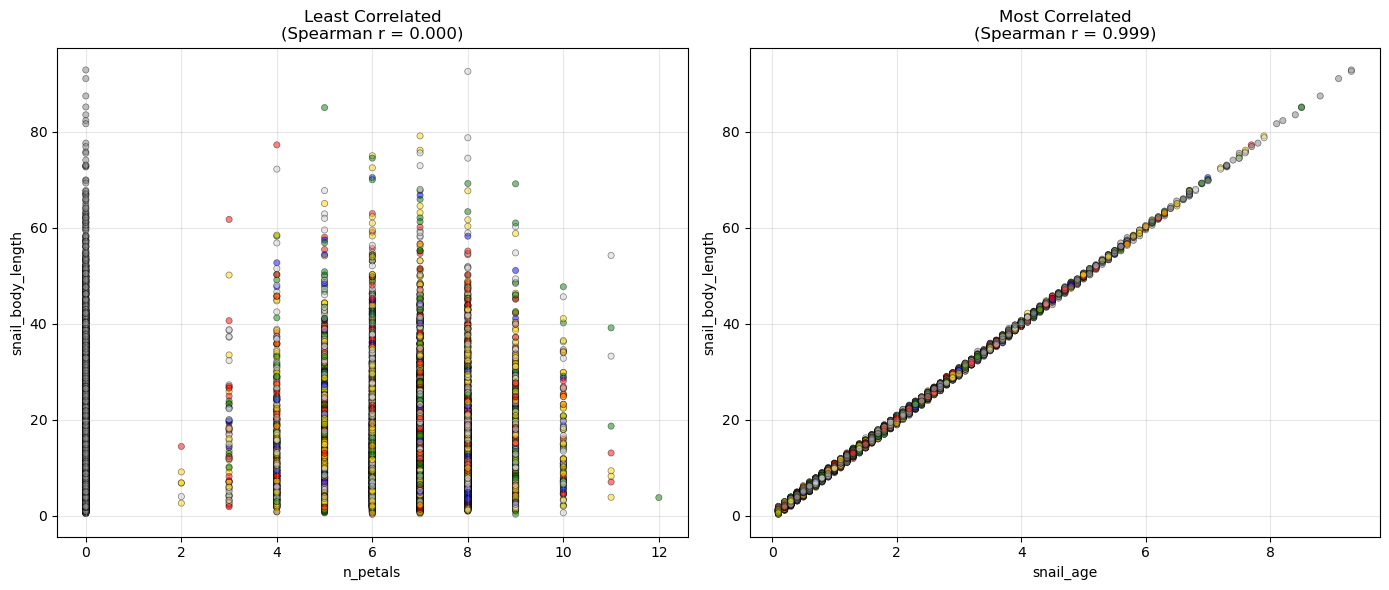

Saved: data_relationships.pdf


In [27]:
corr_values = correlation_matrix.values
np.fill_diagonal(corr_values, np.nan)

min_corr_idx = np.unravel_index(np.nanargmin(np.abs(corr_values)), corr_values.shape)
min_corr = correlation_matrix.iloc[min_corr_idx[0], min_corr_idx[1]]
min_feat1 = numeric_data.columns[min_corr_idx[0]]
min_feat2 = numeric_data.columns[min_corr_idx[1]]

max_corr_idx = np.unravel_index(np.nanargmax(np.abs(corr_values)), corr_values.shape)
max_corr = correlation_matrix.iloc[max_corr_idx[0], max_corr_idx[1]]
max_feat1 = numeric_data.columns[max_corr_idx[0]]
max_feat2 = numeric_data.columns[max_corr_idx[1]]

print(f"\nLeast correlated: {min_feat1} vs {min_feat2} (r={min_corr:.3f})")
print(f"Most correlated: {max_feat1} vs {max_feat2} (r={max_corr:.3f})")

color_map = {
    'red': 'red',
    'blue': 'blue',
    'yellow': 'gold',
    'white': 'lightgray',
    'purple': 'green',
    'N/A': 'gray'
}
colors = clean_df['petal_color'].map(color_map)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(clean_df[min_feat1], clean_df[min_feat2], 
                c=colors, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(min_feat1)
axes[0].set_ylabel(min_feat2)
axes[0].set_title(f'Least Correlated\n(Spearman r = {min_corr:.3f})')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(clean_df[max_feat1], clean_df[max_feat2], 
                c=colors, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(max_feat1)
axes[1].set_ylabel(max_feat2)
axes[1].set_title(f'Most Correlated\n(Spearman r = {max_corr:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data_relationships.pdf')
plt.show()

print("Saved: data_relationships.pdf")


In [28]:
import os  # do not delete this import
assert os.path.exists("data_features.pdf")
assert os.path.exists("data_correlation.pdf")
assert os.path.exists("data_relationships.pdf")